In [61]:
from os import listdir
from os.path import isfile, join

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [62]:
image_root_path = "data/right_hand_fist_amalia"
image_paths = [join(image_root_path, f) for f in listdir(image_root_path) if isfile(join(image_root_path, f))]
image_names = [f for f in listdir(image_root_path) if isfile(join(image_root_path, f))]

In [63]:
# Load the images using opencv
images = [cv2.imread(path) for path in image_paths]
len(images)

247

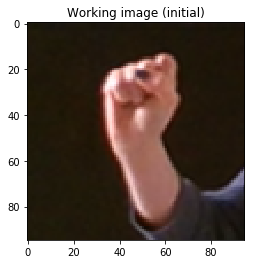

In [64]:
def show_opencv_img(image, title):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Show one of the images.
working_image = images[4]
show_opencv_img(working_image, "Working image (initial)")

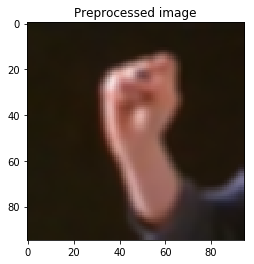

In [65]:
def basic_preprocessing_steps(img):
    new_img = cv2.blur(img,(5,5))
    return new_img

# Test some preprocessing steps.
preprocessed_image = basic_preprocessing_steps(working_image)
show_opencv_img(preprocessed_image, "Preprocessed image")

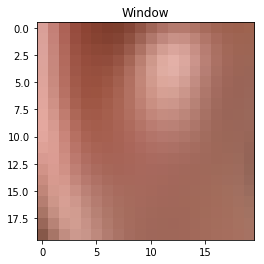

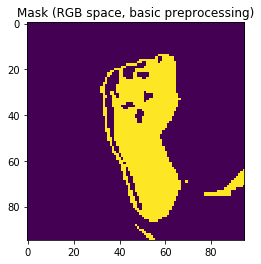

In [66]:
def hand_segmentation(img, preprocessing_fn, window_size=5, tol=50):
    # Apply preprocessing (could include color space transformation, etc)
    img = preprocessing_fn(img.copy())
    
    # Take a window from the center of the image
    center_point = (int(img.shape[0] / 2), int(img.shape[1] / 2))
    window = img[center_point[0]-window_size:center_point[0]+window_size, center_point[1]-window_size:center_point[1]+window_size, :]    
    show_opencv_img(window, "Window")
    
    #print(window)
    
    # Compute the average value for the pixels in this window.
    avg_pixel = np.average(window, axis=(0,1))

    # Create a mask of all pixels within the value of the average (to a given tolerance)
    mask = np.linalg.norm(working_image - avg_pixel, axis=2) < tol
    return mask
    
mask = hand_segmentation(working_image, basic_preprocessing_steps, window_size=10, tol=100)
plt.imshow(mask)
plt.title("Mask (RGB space, basic preprocessing)")
plt.show()

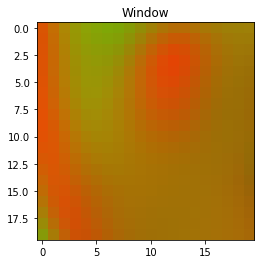

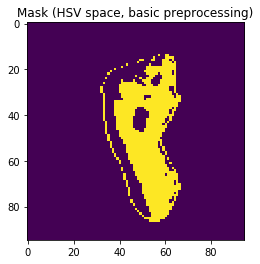

In [67]:
# Try out new preprocessing functions, but keep the same segmentation idea.
def hsv_preprocessing(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return basic_preprocessing_steps(new_img)

mask = hand_segmentation(working_image, hsv_preprocessing, window_size=10, tol=100)
plt.imshow(mask)
plt.title("Mask (HSV space, basic preprocessing)")
plt.show()

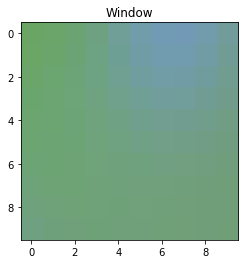

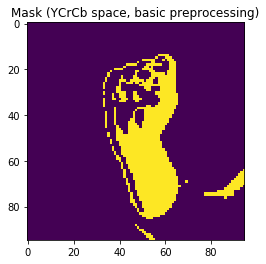

In [68]:
def yCrCb_preprocessing(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    return basic_preprocessing_steps(new_img)

mask = hand_segmentation(working_image, yCrCb_preprocessing, window_size=5, tol=100)
plt.imshow(mask)
plt.title("Mask (YCrCb space, basic preprocessing)")
plt.show()

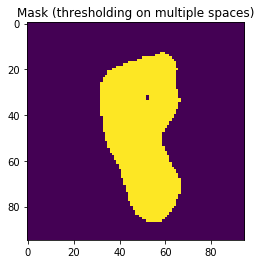

In [69]:
def condition_1(rgb_img, hsv_img, ycrcb_img):
    rgb = rgb_img
    hsv = hsv_img
    ycrcb = ycrcb_img
    return (hsv[:,:,0] >= 0) & (hsv[:,:,0] <= 25) & (hsv[:,:,1] >= 0.23 * 255) \
        & (hsv[:,:,1] <= 0.68 * 255) & (rgb[:,:,0] > 95) & (rgb[:,:,1] > 40) \
        & (rgb[:,:,2] > 20) & (rgb[:,:,0] > rgb[:,:,1]) & (rgb[:,:,0] > rgb[:,:,2])  \
        & (np.abs(rgb[:,:,0] - rgb[:,:,1]) > 15)

def condition_2(rgb_img, hsv_img, ycrcb_img):
    rgb = rgb_img
    hsv = hsv_img
    ycrcb = ycrcb_img
    return (rgb[:,:,0] > 95) & (rgb[:,:,1] > 40) & (rgb[:,:,2] > 20) \
        & (rgb[:,:,0] > rgb[:,:,1]) & (rgb[:,:,0] > rgb[:,:,2]) & (np.abs(rgb[:,:,0] - rgb[:,:,1]) > 15) \
        & (ycrcb[:,:,2] > 85) & (ycrcb[:,:,0] > 80) & (ycrcb[:,:,1] <= 1.5862*ycrcb[:,:,2]+20) \
        & (ycrcb[:,:,1] >= 0.3448*ycrcb[:,:,2]+76.2069) & (ycrcb[:,:,1] >= -4.5652*ycrcb[:,:,2]+234.5652) \
        & (ycrcb[:,:,1] <= -1.15*ycrcb[:,:,2]+301.75) & (ycrcb[:,:,1] <= -2.2857*ycrcb[:,:,2]+432.85)

def skin_segmentation_thresholds(img):
    """
    Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf
    
    Perform thresholding in RGB, HSV and YCrCb at the same time.
    
    NOTE: 
    OpenCV color ranges are: H from 0-179, S and V from 0-255
    """
    
    img = basic_preprocessing_steps(img)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    ycrcb_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    
    mask = condition_1(rgb_img, hsv_img, ycrcb_img) | condition_2(rgb_img, hsv_img, ycrcb_img)
            
    return mask
    
# Segmentation with multiple thresholds.
mask = skin_segmentation_thresholds(working_image).astype(np.uint8)
plt.imshow(mask)
plt.title("Mask (thresholding on multiple spaces)")
plt.show()

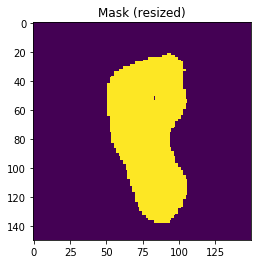

In [70]:
# Resize to a fixed size (will be useful when classifying later)
mask_resized = cv2.resize(mask, (150, 150), interpolation=cv2.INTER_NEAREST)
plt.imshow(mask_resized)
plt.title("Mask (resized)")
plt.show()

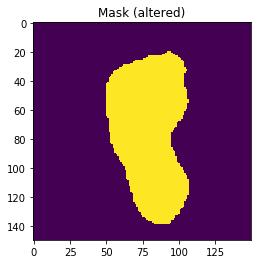

In [71]:
# Apply some morphological operations.
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
mask_altered = mask_resized
mask_altered = cv2.dilate(mask_resized, kernel, iterations = 1)
#mask_altered = cv2.erode(mask_resized, kernel, iterations = 1)
#mask_altered = cv2.morphologyEx(mask_resized, cv2.MORPH_CLOSE, kernel)
#mask_altered = cv2.morphologyEx(mask_resized, cv2.MORPH_OPEN, kernel)
#mask_altered = cv2.morphologyEx(mask_resized, cv2.MORPH_OPEN, kernel)
plt.imshow(mask_altered)
plt.title("Mask (altered)")
plt.show()

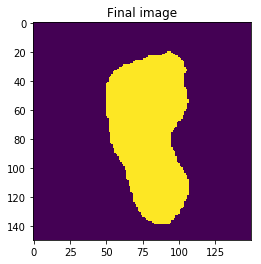

In [72]:
# Try to extract contours here. My intuition is that the hand should be the biggest contour we find.
_, contours, _ = cv2.findContours(mask_altered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
if contours != []:
    max_contour = max(contours, key = cv2.contourArea)
    final_image = np.zeros(mask_altered.shape, np.uint8)
    cv2.drawContours(final_image, [max_contour], -1, (255,0,0), thickness=cv2.FILLED)
    plt.imshow(final_image)
    plt.title("Final image")
    plt.show()

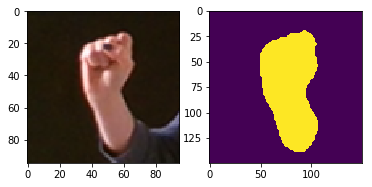

In [73]:
# Side by side plot of original and final :)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cv2.cvtColor(working_image, cv2.COLOR_BGR2RGB))
ax2.imshow(final_image)

In [74]:
def hand_segmentation(img):
    # Perform thresholding segmentation and resize to a fixed size.
    mask = skin_segmentation_thresholds(img).astype(np.uint8)
    mask = cv2.resize(mask, (150, 150), interpolation=cv2.INTER_NEAREST)
    
    # Apply some morphological operations.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask = cv2.dilate(mask, kernel, iterations = 1)
    
    # Extract contours and only keep the biggest contour.
    _, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours) != 0:
        max_contour = max(contours, key = cv2.contourArea)
        final_mask = np.zeros(mask.shape, np.uint8)
        cv2.drawContours(final_mask, [max_contour], -1, (255,0,0), thickness=cv2.FILLED)
        return final_mask
    else:
        return None
    
    return final_mask

In [75]:
dest_path = "data/right_hand_fist_segmented_amalia"
for i, img in enumerate(images):
    mask = hand_segmentation(img)
    if mask is not None:
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        cv2.imwrite(join(dest_path, image_names[i]), mask)